## CartPole

In [1]:
import gym
import numpy as np
import torch
import torch.nn as nn
import torch.utils.data as tud
import random
from tqdm import tqdm
import matplotlib.pyplot as plt
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

In [2]:
env = gym.make('CartPole-v0')

In [3]:
## set seed :2345
seed = 4567
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
random.seed(seed)
env.seed(seed)
env.action_space.np_random.seed(seed)

### Method 3. DATQN

In [4]:
## Experience Set(for experience replay)

class Experience():
    def __init__(self, capacity = 20000):
        self.experience = []  ## store （s,a,r,s'）
        self.capacity = capacity  ## max capacity
        self.volume = 0  ## current capacity
        self.iter = 0
        
    def insert(self, transition):
        if self.volume < self.capacity:
            ## insert directly
            self.experience.append(transition)
            self.volume += 1
        else:
            ## random choose a transition to cover
            self.experience[self.iter] = transition
            self.iter = (self.iter + 1) % self.capacity
    
    def sample(self, batch_size):
        ## random sample a batch including batch_size transitions
        return random.sample(self.experience, k = batch_size)

In [5]:
experience = Experience()

for e in range(100):
    s0 = env.reset()
    is_end = False
    while not is_end:
        action = env.action_space.sample()
        s1, reward, is_end, _ = env.step(action)
        experience.insert([s0,action,reward,s1])
        s0 = s1

In [6]:
### Network: Put AutoEncoder and DQN together

class DATQN(nn.Module):
    def __init__(self, obs_space, hidden_dim, output_dim, action_space):
        super(DATQN, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(obs_space, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.ReLU(),
            nn.Linear(hidden_dim // 2, hidden_dim // 4),
            nn.ReLU(),
            nn.Linear(hidden_dim // 4, output_dim)
        )
        self.decoder = nn.Sequential(
            nn.Linear(output_dim, hidden_dim // 4),
            nn.ReLU(),
            nn.Linear(hidden_dim // 4, hidden_dim // 2),
            nn.ReLU(),
            nn.Linear(hidden_dim // 2, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, obs_space)
        )
        self.QNetwork = nn.Linear(output_dim, action_space)
        
    def forward(self, x):
        hidden = self.encoder(x)
        output = self.decoder(hidden)
        q_table = self.QNetwork(hidden)
        
        return output, q_table


In [7]:
## Agent

class DATQNAgent():
    def __init__(self, env, experience, hidden_dim, output_dim, gamma = 0.9, epsilon = 0.1, decay_rate = 1, learning_rate = 1e-4):
        self.env = env
        self.action_space = env.action_space  
        self.obs_space = env.observation_space.shape[0]
        self.action_len = len([i for i in range(self.action_space.n)])
        self.experience = experience
        
        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
        self.behaviour_QNetwork = DATQN(self.obs_space, hidden_dim, output_dim, self.action_len).to(self.device)
        self.target_QNetwork = DATQN(self.obs_space, hidden_dim, output_dim, self.action_len).to(self.device)
        self.loss_fn = nn.MSELoss(reduction = 'mean')
        self.optimizer = torch.optim.Adam(self.behaviour_QNetwork.parameters(), lr = learning_rate)
        
        self.epsilon = epsilon
        self.decay_rate = decay_rate
        self.gamma = gamma
        
    def policy(self, state, epsilon = 0.1):
        output, q_table = self.behaviour_QNetwork(state)
        if np.random.random() < epsilon:
            action = self.action_sapce.sample()
        else:
            action = torch.argmax(q_table).item()
            
        return action, output
    
    def learn(self, batch_size, display = False):
        s0 = self.env.reset()
        if display:
            self.env.render()
        is_end = False
        episode_reward = 0
        
        while not is_end:
            ## choose an action and make a step
            output, q_table = self.behaviour_QNetwork(torch.Tensor(s0).to(self.device))
            if np.random.random() < self.epsilon:
                a0 = self.action_space.sample()
            else:
                q_table = q_table.detach()
                a0 = torch.argmax(q_table).item()
            # a0, output = self.policy(s0, epsilon = self.epsilon)
            s1, reward, is_end, _ = self.env.step(a0)
            if display:
                self.env.render()
            if is_end:
                s1 = np.array([100,100,100,100])
            ## store the transition into experience
            self.experience.insert([s0,a0,reward,s1])
            ## sample minibatch from experience
            minibatch = self.experience.sample(batch_size = batch_size)
            s, a, r, s_next = [], [], [], []
            for batch in minibatch:
                s.append(batch[0])
                a.append(batch[1])
                r.append(batch[2])
                s_next.append(batch[3])
            s = torch.Tensor(s).to(self.device)
            a = torch.LongTensor(a).to(self.device).reshape(-1,1)
            r = torch.Tensor(r).to(self.device).reshape(-1,1)
            s_next = torch.Tensor(s_next).to(self.device)
            Q_target = r + self.gamma * torch.max(self.target_QNetwork(s_next)[1],1)[0].reshape(-1,1) * (s_next[:,0] != 100).reshape(-1,1)
            s_output, s_q_table = self.behaviour_QNetwork(s)
            Q_behaviour = s_q_table.gather(1,a)
            ## compute loss
            loss_Q = self.loss_fn(Q_target, Q_behaviour)
            loss_AE = self.loss_fn(s, s_output)
            loss_ep = self.loss_fn(torch.Tensor(s0).to(self.device), output)
            loss = loss_Q + loss_AE + loss_ep
            ## back prop
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()
            ## iteration
            s0 = s1
            episode_reward += reward
            
            #print(loss_Q.item(), loss_AE.item(), loss_ep.item())
        
        ## update target network
        self.target_QNetwork.load_state_dict(self.behaviour_QNetwork.state_dict())
        self.epsilon *= self.decay_rate
            
        return episode_reward, loss.item()
    
    def save_model(self):
        torch.save(self.behaviour_QNetwork, 'saved_model\DATQN')
        
    def load_model(self):
        self.behaviour_QNetwork = torch.load('saved_model\DATQN')
        self.target_QNetwork.load_state_dict(self.behaviour_QNetwork.state_dict())
            

In [8]:
datqn_agent = DATQNAgent(env, experience, hidden_dim = 16, output_dim = 3, gamma = 0.99, 
                         epsilon = 0.1, decay_rate = 0.9, learning_rate = 1e-3)

MAX_EPISODE = 2000
datqn_episode_reward = []
datqn_loss = []
average_100_step = []

save_flag = False
max_reward = 0

for e in tqdm(range(MAX_EPISODE)):
    reward, loss = datqn_agent.learn(batch_size = 100, display = False)
    datqn_episode_reward.append(reward)
    avg_mean = np.mean(datqn_episode_reward[-100:])
    average_100_step.append(avg_mean)
    datqn_loss.append(loss)
    
    ## save model
    if avg_mean > 180:
        if save_flag == False:
            datqn_agent.save_model()
            save_flag = True
            max_reward = avg_mean
            print("model saved, episode:",e,"average mean of last 100 episodes:",avg_mean)
        else:
            if avg_mean >= max_reward:
                datqn_agent.save_model()
                max_reward = avg_mean
                print("model saved, episode:",e,"average mean of last 100 episodes:",avg_mean)
    
    

 17%|█████████████▌                                                                 | 343/2000 [03:20<44:13,  1.60s/it]

model saved, episode: 342 average mean of last 100 episodes: 181.29


 17%|█████████████▌                                                                 | 344/2000 [03:21<44:44,  1.62s/it]

model saved, episode: 343 average mean of last 100 episodes: 182.21


 17%|█████████████▋                                                                 | 345/2000 [03:23<44:20,  1.61s/it]

model saved, episode: 344 average mean of last 100 episodes: 183.93


 17%|█████████████▋                                                                 | 346/2000 [03:24<43:08,  1.56s/it]

model saved, episode: 345 average mean of last 100 episodes: 185.65


 17%|█████████████▋                                                                 | 347/2000 [03:26<41:57,  1.52s/it]

model saved, episode: 346 average mean of last 100 episodes: 185.89


 17%|█████████████▋                                                                 | 348/2000 [03:27<40:49,  1.48s/it]

model saved, episode: 347 average mean of last 100 episodes: 186.49


 17%|█████████████▊                                                                 | 349/2000 [03:29<39:39,  1.44s/it]

model saved, episode: 348 average mean of last 100 episodes: 188.15


 18%|█████████████▊                                                                 | 350/2000 [03:30<39:46,  1.45s/it]

model saved, episode: 349 average mean of last 100 episodes: 189.5


 18%|██████████████▏                                                                | 358/2000 [03:43<42:36,  1.56s/it]

model saved, episode: 357 average mean of last 100 episodes: 189.5


 18%|██████████████▏                                                                | 359/2000 [03:44<42:41,  1.56s/it]

model saved, episode: 358 average mean of last 100 episodes: 189.72


 18%|██████████████▏                                                                | 360/2000 [03:46<41:46,  1.53s/it]

model saved, episode: 359 average mean of last 100 episodes: 189.98


 18%|██████████████▎                                                                | 361/2000 [03:47<41:13,  1.51s/it]

model saved, episode: 360 average mean of last 100 episodes: 190.23


 18%|██████████████▎                                                                | 362/2000 [03:48<38:57,  1.43s/it]

model saved, episode: 361 average mean of last 100 episodes: 190.42


 18%|██████████████▎                                                                | 363/2000 [03:50<39:24,  1.44s/it]

model saved, episode: 362 average mean of last 100 episodes: 190.97


 18%|██████████████▍                                                                | 364/2000 [03:51<39:06,  1.43s/it]

model saved, episode: 363 average mean of last 100 episodes: 191.47


 18%|██████████████▍                                                                | 365/2000 [03:52<37:20,  1.37s/it]

model saved, episode: 364 average mean of last 100 episodes: 191.59


 18%|██████████████▍                                                                | 366/2000 [03:54<40:14,  1.48s/it]

model saved, episode: 365 average mean of last 100 episodes: 191.81


 18%|██████████████▍                                                                | 367/2000 [03:56<39:34,  1.45s/it]

model saved, episode: 366 average mean of last 100 episodes: 191.91


 18%|██████████████▌                                                                | 368/2000 [03:57<37:46,  1.39s/it]

model saved, episode: 367 average mean of last 100 episodes: 191.99


 18%|██████████████▌                                                                | 369/2000 [03:58<34:43,  1.28s/it]

model saved, episode: 368 average mean of last 100 episodes: 192.02


 18%|██████████████▌                                                                | 370/2000 [03:59<33:50,  1.25s/it]

model saved, episode: 369 average mean of last 100 episodes: 192.2


 19%|██████████████▊                                                                | 374/2000 [04:05<43:50,  1.62s/it]

model saved, episode: 373 average mean of last 100 episodes: 192.75


 19%|██████████████▊                                                                | 375/2000 [04:08<50:31,  1.87s/it]

model saved, episode: 374 average mean of last 100 episodes: 193.33


 19%|██████████████▊                                                                | 376/2000 [04:09<49:52,  1.84s/it]

model saved, episode: 375 average mean of last 100 episodes: 194.0


 19%|██████████████▉                                                                | 377/2000 [04:11<49:40,  1.84s/it]

model saved, episode: 376 average mean of last 100 episodes: 194.38


 19%|██████████████▉                                                                | 378/2000 [04:13<46:57,  1.74s/it]

model saved, episode: 377 average mean of last 100 episodes: 194.81


 19%|██████████████▉                                                                | 379/2000 [04:14<45:02,  1.67s/it]

model saved, episode: 378 average mean of last 100 episodes: 194.81


 19%|███████████████                                                                | 380/2000 [04:16<43:53,  1.63s/it]

model saved, episode: 379 average mean of last 100 episodes: 194.81


 19%|███████████████                                                                | 381/2000 [04:17<43:06,  1.60s/it]

model saved, episode: 380 average mean of last 100 episodes: 194.81


 19%|███████████████                                                                | 382/2000 [04:19<45:22,  1.68s/it]

model saved, episode: 381 average mean of last 100 episodes: 194.96


 19%|███████████████▏                                                               | 383/2000 [04:21<44:36,  1.66s/it]

model saved, episode: 382 average mean of last 100 episodes: 194.96


 19%|███████████████▏                                                               | 384/2000 [04:23<45:03,  1.67s/it]

model saved, episode: 383 average mean of last 100 episodes: 194.96


 19%|███████████████▏                                                               | 385/2000 [04:24<45:01,  1.67s/it]

model saved, episode: 384 average mean of last 100 episodes: 194.96


 19%|███████████████▏                                                               | 386/2000 [04:26<44:51,  1.67s/it]

model saved, episode: 385 average mean of last 100 episodes: 194.96


 19%|███████████████▎                                                               | 387/2000 [04:27<43:32,  1.62s/it]

model saved, episode: 386 average mean of last 100 episodes: 194.99


 19%|███████████████▎                                                               | 388/2000 [04:29<42:37,  1.59s/it]

model saved, episode: 387 average mean of last 100 episodes: 194.99


 19%|███████████████▎                                                               | 389/2000 [04:30<42:07,  1.57s/it]

model saved, episode: 388 average mean of last 100 episodes: 194.99


 20%|███████████████▍                                                               | 390/2000 [04:32<44:01,  1.64s/it]

model saved, episode: 389 average mean of last 100 episodes: 194.99


 20%|███████████████▍                                                               | 391/2000 [04:34<44:08,  1.65s/it]

model saved, episode: 390 average mean of last 100 episodes: 194.99


 20%|███████████████▍                                                               | 392/2000 [04:35<43:39,  1.63s/it]

model saved, episode: 391 average mean of last 100 episodes: 194.99


 20%|███████████████▌                                                               | 393/2000 [04:37<44:23,  1.66s/it]

model saved, episode: 392 average mean of last 100 episodes: 194.99


 20%|███████████████▌                                                               | 394/2000 [04:39<44:48,  1.67s/it]

model saved, episode: 393 average mean of last 100 episodes: 194.99


 20%|███████████████▌                                                               | 395/2000 [04:41<44:29,  1.66s/it]

model saved, episode: 394 average mean of last 100 episodes: 194.99


 20%|███████████████▋                                                               | 396/2000 [04:42<45:05,  1.69s/it]

model saved, episode: 395 average mean of last 100 episodes: 194.99


 20%|███████████████▋                                                               | 397/2000 [04:44<45:40,  1.71s/it]

model saved, episode: 396 average mean of last 100 episodes: 194.99


 20%|███████████████▋                                                               | 398/2000 [04:46<45:05,  1.69s/it]

model saved, episode: 397 average mean of last 100 episodes: 194.99


 20%|███████████████▊                                                               | 399/2000 [04:47<44:42,  1.68s/it]

model saved, episode: 398 average mean of last 100 episodes: 194.99


 20%|███████████████▊                                                               | 400/2000 [04:49<43:45,  1.64s/it]

model saved, episode: 399 average mean of last 100 episodes: 194.99


 20%|███████████████▊                                                               | 401/2000 [04:51<48:12,  1.81s/it]

model saved, episode: 400 average mean of last 100 episodes: 194.99


 20%|███████████████▉                                                               | 402/2000 [04:53<48:15,  1.81s/it]

model saved, episode: 401 average mean of last 100 episodes: 194.99


 20%|███████████████▉                                                               | 403/2000 [04:55<46:32,  1.75s/it]

model saved, episode: 402 average mean of last 100 episodes: 194.99


 20%|███████████████▉                                                               | 404/2000 [04:56<45:13,  1.70s/it]

model saved, episode: 403 average mean of last 100 episodes: 194.99


 20%|███████████████▉                                                               | 405/2000 [04:58<46:08,  1.74s/it]

model saved, episode: 404 average mean of last 100 episodes: 194.99


 20%|████████████████                                                               | 406/2000 [05:00<46:50,  1.76s/it]

model saved, episode: 405 average mean of last 100 episodes: 194.99


 20%|████████████████                                                               | 407/2000 [05:01<45:53,  1.73s/it]

model saved, episode: 406 average mean of last 100 episodes: 194.99


 20%|████████████████                                                               | 408/2000 [05:03<45:04,  1.70s/it]

model saved, episode: 407 average mean of last 100 episodes: 194.99


 20%|████████████████▏                                                              | 409/2000 [05:05<44:21,  1.67s/it]

model saved, episode: 408 average mean of last 100 episodes: 194.99


 20%|████████████████▏                                                              | 410/2000 [05:06<44:18,  1.67s/it]

model saved, episode: 409 average mean of last 100 episodes: 194.99


 21%|████████████████▏                                                              | 411/2000 [05:08<44:04,  1.66s/it]

model saved, episode: 410 average mean of last 100 episodes: 194.99


 21%|████████████████▎                                                              | 412/2000 [05:10<44:02,  1.66s/it]

model saved, episode: 411 average mean of last 100 episodes: 195.09


 21%|████████████████▎                                                              | 413/2000 [05:11<44:08,  1.67s/it]

model saved, episode: 412 average mean of last 100 episodes: 195.09


 21%|████████████████▎                                                              | 414/2000 [05:13<44:02,  1.67s/it]

model saved, episode: 413 average mean of last 100 episodes: 195.09


 21%|████████████████▍                                                              | 415/2000 [05:15<43:22,  1.64s/it]

model saved, episode: 414 average mean of last 100 episodes: 195.09


 21%|████████████████▍                                                              | 416/2000 [05:16<42:43,  1.62s/it]

model saved, episode: 415 average mean of last 100 episodes: 195.09


 21%|████████████████▍                                                              | 417/2000 [05:18<42:07,  1.60s/it]

model saved, episode: 416 average mean of last 100 episodes: 195.09


 21%|████████████████▌                                                              | 418/2000 [05:19<41:44,  1.58s/it]

model saved, episode: 417 average mean of last 100 episodes: 195.09


 21%|████████████████▌                                                              | 419/2000 [05:21<41:39,  1.58s/it]

model saved, episode: 418 average mean of last 100 episodes: 195.09


 21%|████████████████▌                                                              | 420/2000 [05:22<41:58,  1.59s/it]

model saved, episode: 419 average mean of last 100 episodes: 195.09


 21%|████████████████▋                                                              | 421/2000 [05:24<44:56,  1.71s/it]

model saved, episode: 420 average mean of last 100 episodes: 195.09


 21%|████████████████▋                                                              | 422/2000 [05:26<43:55,  1.67s/it]

model saved, episode: 421 average mean of last 100 episodes: 195.09


 21%|████████████████▋                                                              | 423/2000 [05:28<43:34,  1.66s/it]

model saved, episode: 422 average mean of last 100 episodes: 195.09


 21%|████████████████▋                                                              | 424/2000 [05:29<43:22,  1.65s/it]

model saved, episode: 423 average mean of last 100 episodes: 195.09


 21%|████████████████▊                                                              | 425/2000 [05:31<43:50,  1.67s/it]

model saved, episode: 424 average mean of last 100 episodes: 195.09


 21%|████████████████▊                                                              | 426/2000 [05:33<43:32,  1.66s/it]

model saved, episode: 425 average mean of last 100 episodes: 195.09


 21%|████████████████▊                                                              | 427/2000 [05:34<44:44,  1.71s/it]

model saved, episode: 426 average mean of last 100 episodes: 195.09


 21%|████████████████▉                                                              | 428/2000 [05:36<44:47,  1.71s/it]

model saved, episode: 427 average mean of last 100 episodes: 195.09


 21%|████████████████▉                                                              | 429/2000 [05:38<45:13,  1.73s/it]

model saved, episode: 428 average mean of last 100 episodes: 195.09


 22%|████████████████▉                                                              | 430/2000 [05:40<44:28,  1.70s/it]

model saved, episode: 429 average mean of last 100 episodes: 195.09


 22%|█████████████████                                                              | 431/2000 [05:41<44:01,  1.68s/it]

model saved, episode: 430 average mean of last 100 episodes: 195.09


 22%|█████████████████                                                              | 432/2000 [05:43<43:42,  1.67s/it]

model saved, episode: 431 average mean of last 100 episodes: 195.09


 22%|█████████████████                                                              | 433/2000 [05:45<44:03,  1.69s/it]

model saved, episode: 432 average mean of last 100 episodes: 195.09


 22%|█████████████████▏                                                             | 434/2000 [05:46<43:51,  1.68s/it]

model saved, episode: 433 average mean of last 100 episodes: 195.09


 22%|█████████████████▏                                                             | 435/2000 [05:48<43:27,  1.67s/it]

model saved, episode: 434 average mean of last 100 episodes: 195.09


 22%|█████████████████▏                                                             | 436/2000 [05:50<43:47,  1.68s/it]

model saved, episode: 435 average mean of last 100 episodes: 195.09


 22%|█████████████████▎                                                             | 437/2000 [05:51<44:00,  1.69s/it]

model saved, episode: 436 average mean of last 100 episodes: 195.09


 22%|█████████████████▎                                                             | 438/2000 [05:53<43:32,  1.67s/it]

model saved, episode: 437 average mean of last 100 episodes: 195.09


 22%|█████████████████▎                                                             | 439/2000 [05:55<43:05,  1.66s/it]

model saved, episode: 438 average mean of last 100 episodes: 195.09


 22%|█████████████████▍                                                             | 440/2000 [05:56<45:06,  1.74s/it]

model saved, episode: 439 average mean of last 100 episodes: 195.09


 22%|█████████████████▍                                                             | 441/2000 [05:58<44:19,  1.71s/it]

model saved, episode: 440 average mean of last 100 episodes: 195.09


 22%|█████████████████▍                                                             | 442/2000 [06:00<43:24,  1.67s/it]

model saved, episode: 441 average mean of last 100 episodes: 195.09


 22%|█████████████████▍                                                             | 443/2000 [06:01<43:06,  1.66s/it]

model saved, episode: 442 average mean of last 100 episodes: 195.09


 22%|█████████████████▌                                                             | 444/2000 [06:03<43:38,  1.68s/it]

model saved, episode: 443 average mean of last 100 episodes: 195.09


 22%|█████████████████▌                                                             | 445/2000 [06:05<44:35,  1.72s/it]

model saved, episode: 444 average mean of last 100 episodes: 195.09


 22%|█████████████████▌                                                             | 446/2000 [06:07<45:41,  1.76s/it]

model saved, episode: 445 average mean of last 100 episodes: 195.09


 22%|█████████████████▋                                                             | 447/2000 [06:08<45:29,  1.76s/it]

model saved, episode: 446 average mean of last 100 episodes: 195.09


 22%|█████████████████▋                                                             | 448/2000 [06:10<45:15,  1.75s/it]

model saved, episode: 447 average mean of last 100 episodes: 195.09


 22%|█████████████████▋                                                             | 449/2000 [06:12<45:12,  1.75s/it]

model saved, episode: 448 average mean of last 100 episodes: 195.18


 22%|█████████████████▊                                                             | 450/2000 [06:14<45:12,  1.75s/it]

model saved, episode: 449 average mean of last 100 episodes: 195.18


 23%|█████████████████▊                                                             | 451/2000 [06:16<45:49,  1.78s/it]

model saved, episode: 450 average mean of last 100 episodes: 195.39


 23%|█████████████████▊                                                             | 452/2000 [06:17<45:09,  1.75s/it]

model saved, episode: 451 average mean of last 100 episodes: 195.46


 23%|█████████████████▉                                                             | 453/2000 [06:19<43:58,  1.71s/it]

model saved, episode: 452 average mean of last 100 episodes: 195.53


 23%|█████████████████▉                                                             | 454/2000 [06:20<43:26,  1.69s/it]

model saved, episode: 453 average mean of last 100 episodes: 195.53


 23%|█████████████████▉                                                             | 455/2000 [06:22<42:54,  1.67s/it]

model saved, episode: 454 average mean of last 100 episodes: 195.53


 23%|██████████████████                                                             | 456/2000 [06:24<42:17,  1.64s/it]

model saved, episode: 455 average mean of last 100 episodes: 195.53


 23%|██████████████████                                                             | 457/2000 [06:25<42:19,  1.65s/it]

model saved, episode: 456 average mean of last 100 episodes: 195.53


 23%|██████████████████                                                             | 458/2000 [06:27<42:05,  1.64s/it]

model saved, episode: 457 average mean of last 100 episodes: 195.56


 23%|██████████████████▏                                                            | 459/2000 [06:29<41:43,  1.62s/it]

model saved, episode: 458 average mean of last 100 episodes: 195.56


 23%|██████████████████▏                                                            | 460/2000 [06:30<41:45,  1.63s/it]

model saved, episode: 459 average mean of last 100 episodes: 195.77


 23%|██████████████████▏                                                            | 461/2000 [06:32<41:41,  1.63s/it]

model saved, episode: 460 average mean of last 100 episodes: 195.77


 23%|██████████████████▏                                                            | 462/2000 [06:33<41:54,  1.63s/it]

model saved, episode: 461 average mean of last 100 episodes: 196.03


 23%|██████████████████▎                                                            | 463/2000 [06:35<41:45,  1.63s/it]

model saved, episode: 462 average mean of last 100 episodes: 196.03


 23%|██████████████████▎                                                            | 464/2000 [06:37<41:12,  1.61s/it]

model saved, episode: 463 average mean of last 100 episodes: 196.13


 23%|██████████████████▎                                                            | 465/2000 [06:38<40:22,  1.58s/it]

model saved, episode: 464 average mean of last 100 episodes: 196.45


 23%|██████████████████▍                                                            | 466/2000 [06:40<40:11,  1.57s/it]

model saved, episode: 465 average mean of last 100 episodes: 196.71


 23%|██████████████████▍                                                            | 467/2000 [06:41<39:55,  1.56s/it]

model saved, episode: 466 average mean of last 100 episodes: 197.33


 23%|██████████████████▍                                                            | 468/2000 [06:43<39:46,  1.56s/it]

model saved, episode: 467 average mean of last 100 episodes: 197.73


 23%|██████████████████▌                                                            | 469/2000 [06:44<39:46,  1.56s/it]

model saved, episode: 468 average mean of last 100 episodes: 198.33


 24%|██████████████████▌                                                            | 470/2000 [06:46<39:39,  1.56s/it]

model saved, episode: 469 average mean of last 100 episodes: 198.74


 24%|██████████████████▌                                                            | 471/2000 [06:47<40:15,  1.58s/it]

model saved, episode: 470 average mean of last 100 episodes: 199.32


 24%|██████████████████▋                                                            | 472/2000 [06:49<40:15,  1.58s/it]

model saved, episode: 471 average mean of last 100 episodes: 199.76


 24%|██████████████████▋                                                            | 473/2000 [06:51<39:42,  1.56s/it]

model saved, episode: 472 average mean of last 100 episodes: 199.98


 24%|██████████████████▋                                                            | 474/2000 [06:52<39:23,  1.55s/it]

model saved, episode: 473 average mean of last 100 episodes: 199.98


 24%|██████████████████▊                                                            | 475/2000 [06:54<39:21,  1.55s/it]

model saved, episode: 474 average mean of last 100 episodes: 199.98


 24%|██████████████████▊                                                            | 476/2000 [06:55<39:03,  1.54s/it]

model saved, episode: 475 average mean of last 100 episodes: 199.98


 24%|██████████████████▊                                                            | 477/2000 [06:57<39:00,  1.54s/it]

model saved, episode: 476 average mean of last 100 episodes: 199.98


 24%|██████████████████▉                                                            | 478/2000 [06:58<38:51,  1.53s/it]

model saved, episode: 477 average mean of last 100 episodes: 199.98


100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [42:59<00:00,  1.29s/it]


Text(0, 0.5, 'reward')

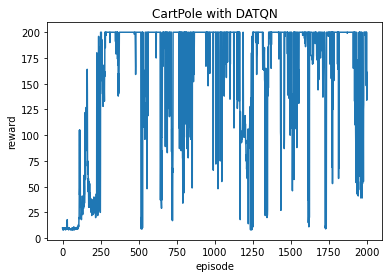

In [9]:
plt.plot(datqn_episode_reward)
plt.title("CartPole with DATQN")
plt.xlabel("episode")
plt.ylabel("reward")

Text(0, 0.5, 'loss')

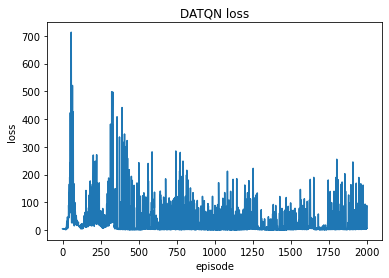

In [12]:
plt.plot(datqn_loss)
plt.title("DATQN loss")
plt.xlabel("episode")
plt.ylabel("loss")

Text(0, 0.5, 'reward')

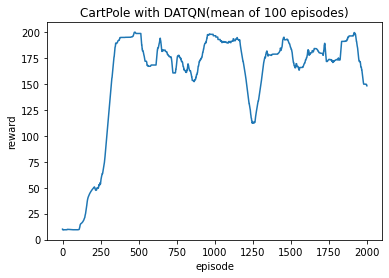

In [13]:
plt.plot(average_100_step)
plt.title("CartPole with DATQN(mean of 100 episodes)")
plt.xlabel("episode")
plt.ylabel("reward")

In [11]:
# save learning curve
datqn_curve = np.array(average_100_step)
np.save('curve\DATQN', datqn_curve)